# Content

In [187]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- [Journals](#Journals)
    - [Loading data](#Loading-data)
    - [Evolution of WoS impact factor for different disciplines](#Evolution-of-WoS-impact-factor-for-different-disciplines)
    - [Fields](#Fields)

In [573]:
from IPython.display import HTML
from itertools import groupby
import collections

import json_lines as jl
import json

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pylab as plt
import numpy as np

%matplotlib inline


def nonull( data ):
    '''
    nonull:
        returns data column with no null entries
    '''
    return data[ data.isnull()==False ]

# Journals

## Loading data

Journals are imported in dataframe format. Two additional dataframes are created, one with content rating information, one with general information about the journal.

- Some contentRating fields have duplicated instances of the WoS IF. (**solved**)
- A numerical journal id (*idNum*) is added to the two new dataframes.

In [477]:
data_json = []
with open('./data/journals/journals_1.jsonl', 'r') as jsonl_file:
    for line in jsonl_file:
        data_json.append(json.loads(line))

#Creating main dataframe with journals data
journals = pd.DataFrame(data_json)
idNum = np.arange(len(journals))

#Filtering journals with contentRating
mask_nr = journals.contentRating.isnull()==False
#Creating new dataframe with journals content rating
journals_rating = pd.DataFrame(json_normalize(np.array(data_json)[mask_nr],
                                              record_path=['contentRating'],
                                              meta=['id'], errors = 'ignore' ))
journals_rating = journals_rating.drop_duplicates()
repeats = [len(list(group)) for key, group in groupby(journals_rating['id'])]
journals_rating['idNum'] = np.repeat(idNum[mask_nr], repeats)
mask_nrr = np.repeat(idNum[mask_nr], repeats)
mask_wos = journals_rating.author == 'impact_factor_wos'

#Filtering journals with about field
mask_ab = journals.about.isnull()==False
#Creating new dataframe with information of journals (about)
journals_about = pd.DataFrame(json_normalize(np.array(data_json)[mask_ab],
                                              record_path=['about'],
                                              meta=['id',], 
                                              record_prefix='category',
                                              meta_prefix='',
                                              sep="_", errors = 'ignore' ))
repeats = [len(list(group)) for key, group in groupby(journals_about['id'])]
journals_about['idNum'] = np.repeat(idNum[mask_ab], repeats)
mask_abr = np.repeat(idNum[mask_ab], repeats)

### Using impact factor as a metric of success

When choosing a suitable journal to publish my research, I, as an author, was most interested in its impact factor (often the WoS IF). As this is the case of most scientist I know of, I will therefore use it as the [metric of success of a journal](https://scholarlykitchen.sspnet.org/2014/05/15/what-researchers-value-from-publishers-canadian-survey/).

In the following histogram, I show the year of foundation for journals with content rating (at least one entry), and without it. Journals without content rating tend to be much newer as they have not collected enough data to be rated. The most recently founded journals might be potential candidates for growth strategies.

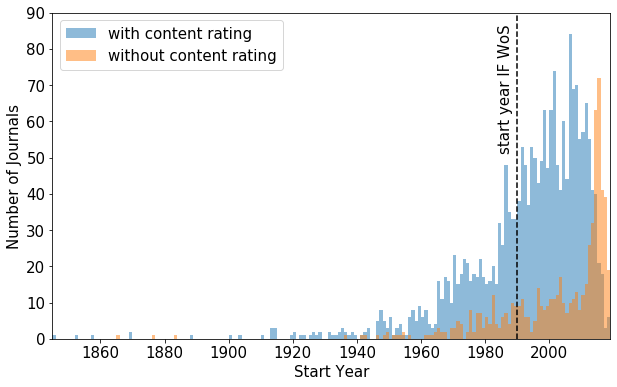

In [169]:
#Plotting start year vs count for journals with and without content rating
min_year = np.min(np.array(nonull(journals.startYear)).astype(int))
max_year = np.max(np.array(nonull(journals.startYear)).astype(int))
start_year_wos = np.min(np.array(nonull(journals_rating.dateCreated[mask_wos])).astype(int))
last_year_wos = np.max(np.array(nonull(journals_rating.dateCreated[mask_wos])).astype(int))
bins = max_year - min_year

plt.figure( figsize = (10,6) )
dm = plt.hist(np.array(nonull(journals.startYear[mask_nr])).astype(int), 
              bins=bins, range=(min_year,max_year), alpha=0.5, label='with content rating')
dm = plt.hist( np.array(nonull(journals.startYear[mask_nr==False])).astype(int), 
              bins=bins, range=(min_year,max_year), alpha=0.5, label='without content rating')

plt.xlabel( 'Start Year', fontsize = 15 )
plt.xlim( min_year, max_year )
plt.xticks( fontsize = 15 )
plt.ylabel( 'Number of Journals', fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.ylim( 0, 90 )

plt.vlines( start_year_wos, 0, 90, ls='--' )
plt.text( start_year_wos-6, 52, 'start year IF WoS', fontsize=15, rotation=90 )
plt.legend( loc='upper left', fontsize = 15 )
plt.show()

## Evolution of WoS impact factor for different disciplines

A new dataframe is created for all disciplines and contains the time evolution of the mean and the top 20\% WoS impact factors of the corresponding journals.

In [526]:
def IF_WoS_props( category, year=2017, percentiles=[50,80], 
                  journals_about=journals_about, journals_rating=journals_rating, complete_dist=False):
    """
    IF_WoS_props: 
        returns percentiles of WoS impact factor for a given discipline and year, number of ranked journals
        and total number of journals
    Parameters
    ----------
    category : string
    year: int
    percentiles: array_like
    journals_about: DataFrame
        Dataframe with general information of the journals.
    journals_rating: DataFrame
        Dataframe with content rating information.
    complete_dist: boolean
        Complete distribution is returned if True
    """
    mask_disc = journals_about.categoryname==category

    mask_journal_disc = np.in1d(journals_rating.idNum[mask_wos], journals_about.idNum[mask_disc])
    mask_year = journals_rating.dateCreated[mask_wos][mask_journal_disc].astype(int) == year
    
    start_years = np.array(journals.startYear[np.in1d(idNum, journals_about.idNum[mask_disc])]).astype(float)
    n_journals = np.sum(start_years[np.isnan(start_years)==False]<year)+np.sum(np.isnan(start_years))
    
    IF_WoS = np.array(nonull(journals_rating.ratingValue[mask_wos][mask_journal_disc][mask_year])).astype(float)
    if complete_dist:
        return IF_WoS
    if np.sum(mask_year) != 0:
        return np.append(np.percentile(IF_WoS,percentiles), [len(IF_WoS), np.max([n_journals,len(IF_WoS)])])
    else:
        return np.append(np.zeros( len(percentiles)+1 ), n_journals)

In [527]:
#Discipline dataframe
disciplines = pd.DataFrame(list(set(journals_about.categoryname.copy()))[1:], columns=['categoryname'])
tmp = np.zeros( len(disciplines) )
for year in np.arange(start_year_wos,last_year_wos+1):
    disciplines["median_%d"%(year)] = tmp
    disciplines["p80_%d"%(year)] = tmp
    disciplines["ranked_journals_%d"%(year)] = tmp
    disciplines["journals_%d"%(year)] = tmp
    
for i_cat, categoryname in enumerate(disciplines.categoryname):
    for year in np.arange(start_year_wos,last_year_wos+1):
        median, p80, nrjournals, njournals = IF_WoS_props( categoryname, year=year )
        disciplines.at[i_cat,'median_%d'%(year)] = median
        disciplines.at[i_cat,'p80_%d'%(year)] = p80
        disciplines.at[i_cat,'ranked_journals_%d'%(year)] = nrjournals
        disciplines.at[i_cat,'journals_%d'%(year)] = njournals

#Saving as pickle
disciplines.to_pickle('./data/journals/disciplines.pkl')

In [535]:
#Loading as pickle if already computed
disciplines = pd.read_pickle('./data/journals/disciplines.pkl')

#Saving category names ordered according to string lenght, along with numer of journals in 2017
np.savetxt('./data/journals/CategoriesNames.txt',
           np.transpose([disciplines['categoryname'][np.argsort(np.vectorize(len)(disciplines['categoryname']))], 
                         disciplines['journals_2017'][np.argsort(np.vectorize(len)(disciplines['categoryname']))]]), 
           fmt="%s\t %d")

#Arrays with medians, p80 and journals to access data
years_disc = np.arange(1990, 2018)
medians_disc = ['median_%d'%year for year in years_disc]
p80_disc = ['p80_%d'%year for year in years_disc]
ranked_journals_disc = ['ranked_journals_%d'%year for year in years_disc]
journals_disc = ['journals_%d'%year for year in years_disc]

#Filtering out categories with no indexed journals
#disciplines = disciplines[np.sum(disciplines[journals_disc],axis=1)!=0]

#Number of disciplines with rated journals 
n_disc = len(disciplines)

#Dictionary of categoryname to index
index_disc = dict(zip(disciplines.categoryname, np.arange(n_disc)))

In [533]:
#Example
disciplines[['categoryname',
             'median_2016', 'p80_2016', 'ranked_journals_2016', 'journals_2016', 
             'median_2017', 'p80_2017', 'ranked_journals_2017', 'journals_2017']][:20]

,categoryname,median_2016,p80_2016,ranked_journals_2016,journals_2016,median_2017,p80_2017,ranked_journals_2017,journals_2017
0,Plasma Physics,6.6565,10.1356,2.0,3.0,6.7760,10.4102,2.0,3.0
1,Oceanography,1.3470,2.4100,19.0,24.0,1.4010,2.4778,19.0,24.0
2,History of Mathematical Sciences,0.5175,0.6432,2.0,8.0,0.6580,0.7030,2.0,8.0
3,Robotics and Automation,1.5880,2.2588,3.0,12.0,1.4230,1.9156,3.0,13.0
4,Nuclear Chemistry,0.6675,1.0362,2.0,7.0,0.7345,1.0024,2.0,8.0
5,Geriatric Care,0.0000,0.0000,0.0,1.0,0.0000,0.0000,0.0,1.0
6,"Biological and Medical Physics, Biophysics",1.4720,2.3980,21.0,38.0,1.8020,2.4350,21.0,38.0
7,"Atoms and Molecules in Strong Fields, Laser Ma...",0.9870,1.0608,2.0,2.0,0.9495,1.0182,2.0,2.0
8,Imaging / Radiology,1.8185,2.4368,30.0,69.0,1.8965,2.8928,30.0,71.0
9,Syntax,0.5980,0.8710,2.0,4.0,0.8825,0.9068,2.0,4.0


### Plant Sciences

Example of evolution of the WoS impact factor distribution for a specific journal.

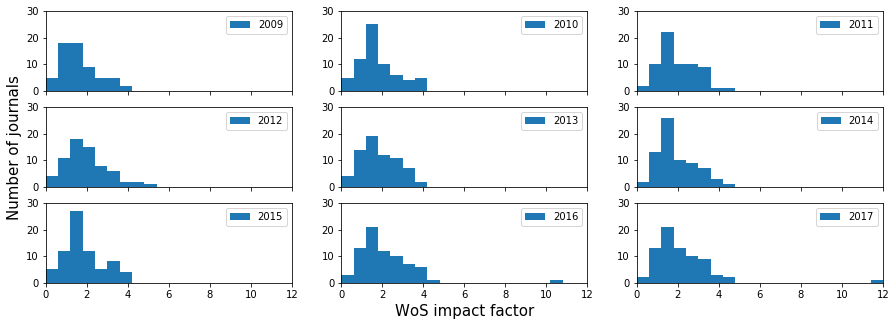

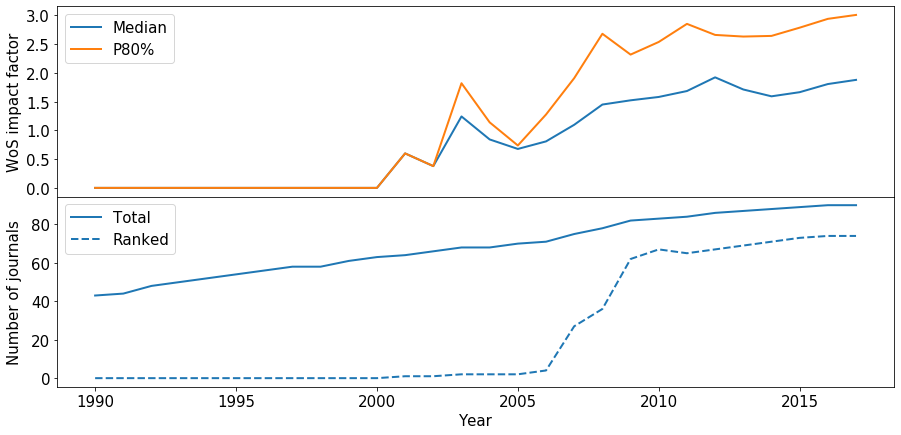

In [551]:
categoryname = 'Plant Sciences'
max_journ = 30
max_if = 12
bins = 20

plt.figure( figsize=(15,5) )
for i_y, year in enumerate(np.arange(2009,2018)):
    distro = IF_WoS_props( categoryname, year=year, complete_dist=True)
    plt.subplot( 3,3,i_y+1 )
    plt.hist( distro, range=(0,max_if), bins=bins, label=year )
    plt.xlim(0,max_if)
    plt.ylim(0,max_journ)
    plt.legend( loc='upper right' )
    if i_y<6:
        plt.xticks( np.arange(0,max_if+2,2), '' )
    if i_y==3:
        plt.ylabel( "Number of journals", fontsize=15 )
    if i_y==7:
        plt.xlabel( "WoS impact factor", fontsize=15 )
    
    
fig = plt.figure( figsize=(15,7) )
plt.subplots_adjust( hspace=0 )
plt.subplot( 2,1,1 )
median = np.array(disciplines[medians_disc])[index_disc[categoryname]]
p80 = np.array(disciplines[p80_disc])[index_disc[categoryname]]
plt.plot( years_disc, median, lw=2, label='Median' )
plt.plot( years_disc, p80, lw=2, label='P80%' )
plt.xticks( np.arange(1990,2016,5), '' )
plt.ylabel( "WoS impact factor", fontsize=15 )
plt.yticks( fontsize=15 )
plt.legend( loc='upper left', fontsize=15 )

plt.subplot( 2,1,2 )
njournals = np.array(disciplines[journals_disc])[index_disc[categoryname]]
nrjournals = np.array(disciplines[ranked_journals_disc])[index_disc[categoryname]]
plt.plot( years_disc, njournals, lw=2, label='Total', color='#1f77b4', ls='-' )
plt.plot( years_disc, nrjournals, lw=2, label='Ranked', color='#1f77b4', ls='--' )
plt.xlabel( "Year", fontsize=15 )
plt.xticks( fontsize=15 )
plt.ylabel( "Number of journals", fontsize=15 )
plt.yticks( fontsize=15 )
fig.align_ylabels()
plt.legend( loc='upper left', fontsize=15 )

plt.show()

The growth of the impact factor $G_{\mathrm{WoS}}$ of each discipline is computed as:

$$ G_{\mathrm{WoS}} = \frac{\Delta \textrm{IF}_{\textrm{WoS}}}{\Delta t} = \frac{\textrm{IF}^{2017}_{\textrm{WoS}} - \textrm{IF}^{0}_{\textrm{WoS}}}{2017-\textrm{year}^0}, $$

where $\textrm{IF}^{0}_{\textrm{WoS}}$, $\textrm{year}^0$ denote the first impact factor of any journal in that discipline and the year it was recorded, respectively.

In [545]:
disciplines['growth'] = np.sum((np.array(disciplines[medians_disc])[:,1:]-np.array(disciplines[medians_disc])[:,:-1])*(np.array(disciplines[medians_disc])[:,:-1]>0),axis=1)/(np.sum(np.array(disciplines[medians_disc])>0,axis=1)+1e-5)

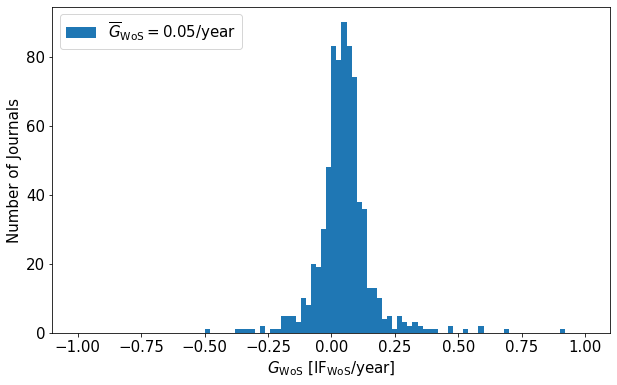

In [546]:
plt.figure( figsize = (10,6) )
plt.hist(disciplines['growth'][disciplines['growth']!=0], range=(-1,1), bins=100, 
         label='$\overline{G}_{\mathrm{WoS}} = %1.2f$/year'%
         (np.mean(disciplines['growth'][disciplines['growth']!=0])))
plt.xticks(fontsize=15)
plt.xlabel( "$G_{\mathrm{WoS}}$ [IF$_{\mathrm{WoS}}$/year]", fontsize=15 )
plt.yticks(fontsize=15)
plt.ylabel( "Number of Journals", fontsize=15 )
#plt.vlines()
plt.legend( loc='upper left', fontsize=15 )
plt.show()

On average, the WoS impact factor growth follows a normal distribution whose mean is about 0.05 per year for all disciplines. Interestingly, some disciplines exhibit negative growth.


## Fields

Although the categorization of journals in different disciplines is useful to identify similar (competing) journals, many disciplines are very narrow and specific. As a consequence, some disciplines have only a few journals (only 1 in some cases), a situation that is not ideal for robust statistical analysis.

In order to mitigate this problem, I will group similar disciplines in a more general category, namely a *Field*. In the order to define a field, I will use the journals that belong to different disciplines as the connectors that link those disciplines together. A group of linked disciplines is a field. (In technical terms, this is called a [Collaboration graph](https://en.wikipedia.org/wiki/Collaboration_graph).)

In [706]:
#Array to quantify links (journals) between disciplines
graph_links = np.zeros((n_disc,n_disc))

#Filling matrix
for i_cat, categoryname in enumerate(disciplines.categoryname):
    mask_cat_tmp = journals_about['categoryname'] == categoryname
    id_tmp = np.array(journals_about['idNum'][mask_cat_tmp].astype(int))
    mask_field_tmp = np.in1d( np.array(journals_about['idNum'].astype(int)), id_tmp )
    mask_no_tmp = journals_about['categoryname'][mask_field_tmp].values != categoryname
    if np.sum(mask_no_tmp)!=0:
        non_repeat_journals_tmp = journals_about['categoryname'][mask_field_tmp][mask_no_tmp]
        mask_nan_tmp = non_repeat_journals_tmp.isnull()==False
        indices_tmp = list(map(index_disc.get, 
                               non_repeat_journals_tmp[mask_nan_tmp]))
        counter = collections.Counter(indices_tmp)
        graph_links[i_cat,list(counter.keys())] = list(counter.values())

In [705]:
disciplines.categoryname[42]

'Microbiology'

In [715]:
disciplines.categoryname[graph_links[42]>0]

1                                           Oceanography
11                                              Mycology
34                                     Protein Structure
37                                          Bacteriology
38                                         Endocrinology
45                                 Biological Microscopy
57                               Pharmacology/Toxicology
63                                     Forensic Medicine
66                                     Organic Chemistry
84                                            Proteomics
88                                          Neurobiology
91                                               Vaccine
94                                     Internal Medicine
101                                          Agriculture
108                                  Solid State Physics
133                                             Oncology
134                         Animal Genetics and Genomics
158                            

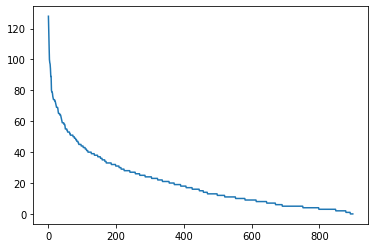

In [709]:
plt.plot(np.sort(np.sum((graph_links>0)&(graph_links<=5),axis=1))[::-1])

In [718]:
disciplines.categoryname[np.argsort(np.sum((graph_links==5),axis=1))[::-1]]

517                               Life Sciences, general
474                                Developmental Biology
94                                     Internal Medicine
769                      Medicine/Public Health, general
841                              Earth Sciences, general
192                                Biochemistry, general
101                                          Agriculture
308                                        Neurosciences
57                               Pharmacology/Toxicology
416                                              Surgery
532                  Operations Research/Decision Theory
798                           Materials Science, general
425     Information Systems Applications (incl.Internet)
340                                           Immunology
433                                 Biomedicine, general
313                                         Rheumatology
434                                 Environment, general
323                            

In [703]:
disciplines.categoryname[np.argsort(np.sum((graph_links>0)&(graph_links<=1),axis=1))[::-1]]

757                                        Public Health
769                      Medicine/Public Health, general
79                              Social Sciences, general
517                               Life Sciences, general
434                                 Environment, general
138                             Quality of Life Research
192                                Biochemistry, general
440                              Sustainable Development
442                                               Ethics
433                                 Biomedicine, general
233            Biomedical Engineering and Bioengineering
801                              Artificial Intelligence
177                                 Cognitive Psychology
669                            Computer Science, general
215                                 Engineering, general
898                                   Physical Chemistry
42                                          Microbiology
302                            

In [659]:
disciplines.categoryname[29]

'Computer Appl. in Life Sciences'

In [678]:
graph_links[679,42]

13.0

In [677]:
graph_links[42,679]

13.0

(array([27.,  8.,  4.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <a list of 19 Patch objects>)

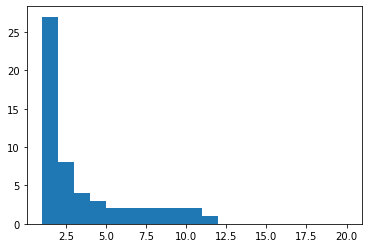

In [657]:
plt.hist(graph_links[29],bins=19, range=(1,20), cumulative=-1)

In [645]:
disciplines.categoryname[graph_links[42]>=5]

11                            Mycology
192              Biochemistry, general
319                           Virology
323                      Biotechnology
438                       Cell Biology
465                            Zoology
478               Medical Microbiology
517             Life Sciences, general
625    Microbial Genetics and Genomics
665               Applied Microbiology
679                  Microbial Ecology
785                       Parasitology
824                            Ecology
846                     Plant Sciences
Name: categoryname, dtype: object

In [461]:
mask_tmp = journals_about['categoryname']=='Psychiatry'
id_tmp = np.array(journals_about['idNum'][mask_tmp].astype(int))
mask_field = np.in1d( np.array(journals_about['idNum'].astype(int)), id_tmp )
mask_no = journals_about['categoryname'][mask_field].values != 'Psychiatry'
journals_about['categoryname'][mask_field].values[mask_no]

['Community and Environmental Psychology',
 'Neurosciences',
 'Neurology',
 'Neurology',
 'Neurosurgery',
 'Public Health',
 'Clinical Psychology',
 'Personality and Social Psychology',
 'Public Health',
 'Health Psychology',
 'Community and Environmental Psychology',
 'Health Promotion and Disease Prevention',
 'Health Informatics',
 'Public Health',
 'Health Administration',
 'Clinical Psychology',
 'Health Informatics',
 'Public Health',
 'Sociology, general',
 'Medicine/Public Health, general',
 'Neurology',
 'Neurosurgery',
 'Psychotherapy',
 'Neurology',
 'Psychotherapy',
 'Psychopharmacology',
 'Forensic Psychiatry',
 'Human Physiology',
 'Neurology',
 'Neurosciences',
 'Health Psychology',
 'Internal Medicine',
 'Public Health',
 'Health Psychology',
 'Psychology, general',
 'Rehabilitation',
 'Community and Environmental Psychology',
 'Epidemiology',
 'Neurosciences',
 'Neurology',
 'Behavioral Therapy',
 'Clinical Psychology',
 'Sociology, general',
 'Education, general',
 'C

/home/sebastian/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(-0.4, 1)

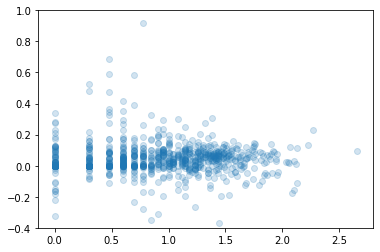

In [543]:
plt.scatter( np.log10(disciplines['journals_2017']), growth, alpha=0.2 )
plt.ylim( -0.4,1 )

In [49]:
journals.keys()

Index(['@context', 'about', 'alternateName', 'contentRating', 'description',
       'editor', 'id', 'inLanguage', 'isAccessibleForFree', 'issn', 'license',
       'name', 'productId', 'publisher', 'publisherImprint', 'sameAs',
       'sdDataset', 'sdDatePublished', 'sdLicense', 'sdPublisher', 'sdSource',
       'startYear', 'type', 'url'],
      dtype='object')

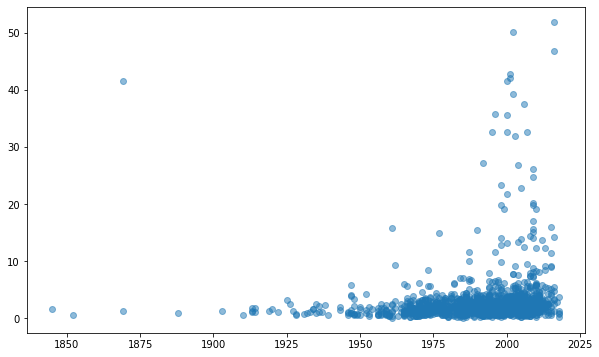

In [286]:
mask_actual = np.array(nonull(journals_rating.dateCreated[mask_wos])).astype(int)==2017
id_journal = np.array(nonull(journals_rating.idNum[mask_wos])).astype(int)[mask_actual]

year_found = np.array(journals.startYear[id_journal]).astype(float)
IFWoS = np.array(nonull(journals_rating.ratingValue[mask_wos])).astype(float)[mask_actual]

plt.figure( figsize = (10,6) )
plt.scatter( year_found, IFWoS, alpha=0.5 )

In [390]:
journals_about['categoryid'][0]

'http://scigraph.springernature.com/ontologies/product-market-codes/H53003'

In [365]:
mask_tmp = journals_about['categoryname']=='Psychiatry'
id_tmp = np.array(journals_about['idNum'][mask_tmp].astype(int))
mask_field = np.in1d( np.array(journals_about['idNum'].astype(int)), id_tmp )
journals_about['categoryname'][mask_field].drop_duplicates().values


array(['Psychiatry', 'Community and Environmental Psychology',
       'Neurosciences', 'Neurology', 'Neurosurgery', 'Public Health',
       'Clinical Psychology', 'Personality and Social Psychology',
       'Health Psychology', 'Health Promotion and Disease Prevention',
       'Health Informatics', 'Health Administration',
       'Sociology, general', 'Medicine/Public Health, general',
       'Psychotherapy', 'Psychopharmacology', 'Forensic Psychiatry',
       'Human Physiology', 'Internal Medicine', 'Psychology, general',
       'Rehabilitation', 'Epidemiology', 'Behavioral Therapy',
       'Education, general', 'Cross Cultural Psychology',
       'Psychosomatic Medicine', 'Behavioral Sciences', 'Pediatrics',
       'Child and Adolescent Psychiatry', 'Neuroradiology',
       'Neuropsychology', 'Law and Psychology',
       'Criminology and Criminal Justice, general', 'Human Genetics',
       'Psychoanalysis', 'Pharmacotherapy', 'Biological Psychology',
       'Neurobiology', 'Animal Mo

In [368]:
np.vectorize?